# EEE6504 - HW3 #
## Jackson Cornell  | Michael Kim ##

In [1]:
import math
import time
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

## Functions ##

In [2]:
# Gaussian kernel
def Kernel(x, kernel_size) :
    return np.exp(-x**2 / kernel_size**2)

In [3]:
# QKLMS filter with MSE cost function
def QKLMS_MSE(x, d, kernel_size, embedding_size, step_size, threshold) :
    # calculate epochs
    epochs = np.size(x) - embedding_size
    # initialize vectors
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    a = np.zeros(epochs)
    growth = np.zeros(epochs)
    C = []
    err = []
    for i in range(epochs) :
        # compute output
        y[i] = 0
        x_vect = np.array(x[i:(i+embedding_size)])
        if (i != 0) :
            y[i] += step_size * np.array(err[0:i]).T @ Kernel(np.linalg.norm(x_vect - np.array(C), 2, axis=1), kernel_size)
        # update error
        e[i] = d[i+embedding_size-1] - y[i]
        # compute minimum distance
        minimum = 1e100
        index = 0
        if (len(C) != 0) :
            min_index = np.argmin(abs(x[i+embedding_size-1] - np.array(C)[:,embedding_size-1]))
            minimum = abs(x[i+embedding_size-1] - np.array(C)[min_index,embedding_size-1])
        # update codebook
        if (minimum > threshold) :
            C.append(x_vect)
            err.append(e[i])
        else :
            err[index] += e[i]
        growth[i] = len(C)
    # return weights and learning curve
    return e**2, y, growth, step_size*np.array(err)

In [4]:
# KRLS filter with MSE cost function
def KRLS_MSE(x, d, lam, kernel_size) :
    # calculate epochs
    epochs = np.size(x)
    # initialize vectors
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    a = np.zeros(epochs)
    growth = np.zeros(epochs)
    r = np.zeros(epochs)
    # iterate through samples
    for i in range(epochs) :
        # calculate vectors
        if (i == 0) :
            Q = np.array(lam + Kernel(x[0], x[0], kernel_size)).inv
            a[0] = Q*d[0]
        else :
            x_v = x[0:i]
            h = Kernel(x[i], x_v, kernel_size).T
            z = Q @ h
            r[i] = lam + Kernel(x[i], x[i], kernel_size) - z.T@h
            #Q = r.inv @ #???
            e[i] = d[i]- h[i].T @ a[i-1]
            #a[i] = #???

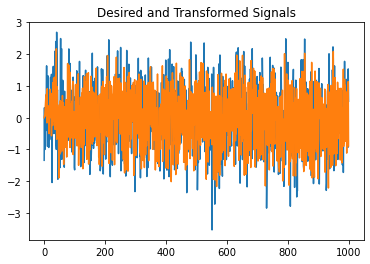

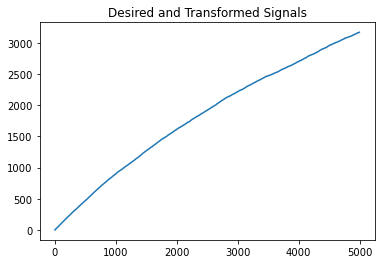

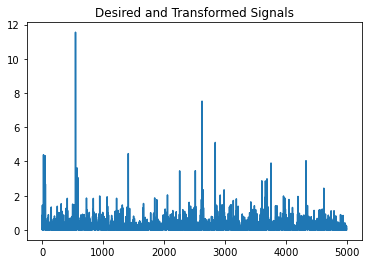

In [6]:
### DELETE LATER ###
mean = 0
var = 1
L = 5002
y = np.random.normal(mean, var, L)
h = np.array([-0.8, 0.7])
t = np.convolve(h, y)[0:L]
q = t + 0.25*(t**2) + 0.11*(t**3)
P = np.sum(q**2) / L
SNR = 10**(15/10)
xn = q + np.sqrt(P/SNR) * np.random.normal(0, 1, L)
x = xn[2:5002]
d = y[0:5000]

step_size = 0.5
embedding_size = 5
kernel_size = 5
eps = 5e-4
J, y, growth, a = QKLMS_MSE(x, d, kernel_size, embedding_size, step_size, eps)

# plot output wave
plt.plot(np.linspace(0, 1000, 1000), d[0:1000])
plt.plot(np.linspace(0, 1000, 1000), y[0:1000])
plt.title("Desired and Transformed Signals")
plt.show()

plt.plot(np.linspace(0, np.size(growth), np.size(growth)), growth)
plt.title("Desired and Transformed Signals")
plt.show()

plt.plot(np.linspace(0, np.size(J), np.size(J)), J)
plt.title("Desired and Transformed Signals")
plt.show()
### DELETE LATER ###